In [1]:
from preprocessors import Preprocessor
from config.data_setting import *
from datasets import BasicDataset
from models.mlp import MultiMLP
import pandas as pd
import torch

from train_tools.EarlyStopper import EarlyStopper
from train_tools.BestSaver import BestSaver
from train_tools.history import *
from train_tools.engine import train_one_epoch, test_one_epoch

In [2]:
# config
num_epochs = 100
batch_size = 32
learning_rate = 1e-4

hidden_dims = [128, 64]

model_save_path = "save_models/mlp_h"+str(len(hidden_dims))+".pt"
result_path = "result/mlp_h"+str(len(hidden_dims))+".csv"
preprocessor = Preprocessor(symbolic_type="onehot", num_min=0, num_max=1, y_min=-1, y_max=1)
X_train = preprocessor.preprocess(train_path)
y_train = preprocessor.y_true
X_test = preprocessor.preprocess(public_path)

# loss function
def mape_loss(preds, targets):
    return torch.abs((targets - preds)/targets).mean()

### Dataset

In [3]:
dataset_train = BasicDataset(X_train, y_train) # dataset
dataset_test = BasicDataset(X_test)
data_loader_train = torch.utils.data.DataLoader(
        dataset_train, batch_size=batch_size, shuffle=True)
data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=batch_size, shuffle=False)
x, y = dataset_train[0]
input_dim = x.shape[0]
output_dim = y.shape[0]
x.shape, y.shape

(torch.Size([40]), torch.Size([1]))

### Model

In [4]:
device = torch.device('cuda')
model = MultiMLP(input_dim=input_dim, hidden_dims=hidden_dims, output_dim=output_dim, out_selection='tanh')
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
early_stopper = EarlyStopper(patience=5, best_criterion='min')
best_saver = BestSaver(model, model_save_path, best_criterion='min')

### Training

Epoch [1] loss: 0.37570250396738236
Epoch [2] loss: 0.2561313694788386
Epoch [3] loss: 0.23395869150028928
Epoch [4] loss: 0.22240047375469105
Epoch [5] loss: 0.20872035272338468
Epoch [6] loss: 0.2055625532369089
Epoch [7] loss: 0.20156547014156115
Epoch [8] loss: 0.20116653078762087
Epoch [9] loss: 0.2002088910414149
Epoch [10] loss: 0.19856815380246742
Epoch [11] loss: 0.1974401911923095
Epoch [12] loss: 0.19553256002457245
Epoch [13] loss: 0.19600675823976813
Epoch [14] loss: 0.19373093247818557
Epoch [15] loss: 0.19200125616043806
Epoch [16] loss: 0.19193394907304775
Epoch [17] loss: 0.19034592938892866
Epoch [18] loss: 0.19011432341421428
Epoch [19] loss: 0.18827208906979018
Epoch [20] loss: 0.18781339697053898
Epoch [21] loss: 0.18663636254875557
Epoch [22] loss: 0.1860513862465387
Epoch [23] loss: 0.1850388676393777
Epoch [24] loss: 0.1850675689258977
Epoch [25] loss: 0.18292320222067443
Epoch [26] loss: 0.1827660612559513
Epoch [27] loss: 0.18209773148207561
Epoch [28] loss: 0

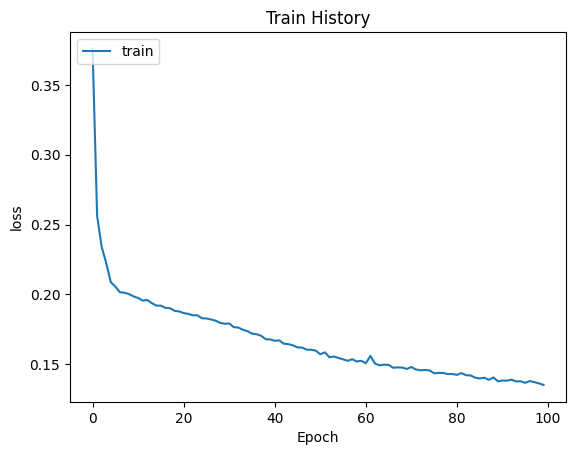

In [5]:
train_history = []
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model=model, data_loader=data_loader_train, optimizer=optimizer, 
                                 criterion=mape_loss, device=device)
    print(f"Epoch [{epoch+1}] loss: {train_loss}")

    if early_stopper.stopJudgment(train_loss):
        print(f"End in epoch {epoch+1}")
        break
    best_saver.saveJudgment(train_loss)
    train_history.append(train_loss)
show_train_history(train_history)

In [6]:
prediction = test_one_epoch(model, data_loader_test, device)
prediction = preprocessor.denormalizeY(prediction)

df = pd.read_csv(sub_template_path)
df = pd.DataFrame(df)
df[price_col] = prediction
df.to_csv(result_path, index=False)